# Chap 04

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

,X,Y
0,24,472
1,24,403
2,26,454
3,32,575
4,33,546


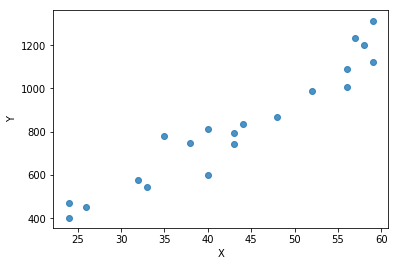

In [7]:
df = pd.read_csv('./chap04/input/data-salary.txt')
display(df.head())
sns.regplot(x='X', y='Y', data=df, fit_reg=False)

### statsmodels

In [4]:
import statsmodels.api as sm

df = sm.add_constant(df)

model = sm.OLS(df['Y'], df[['const', 'X']])
fitted = model.fit()
print(fitted.params)
print(fitted.summary())

/Users/tomohiro/Workspace/RStanBook/.env/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


const   -119.697132
X         21.904201
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     208.2
Date:                Sun, 22 Oct 2017   Prob (F-statistic):           2.47e-11
Time:                        15:48:39   Log-Likelihood:                -114.74
No. Observations:                  20   AIC:                             233.5
Df Residuals:                      18   BIC:                             235.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

Text(0.5,1,'50% and 95% prediction interval')

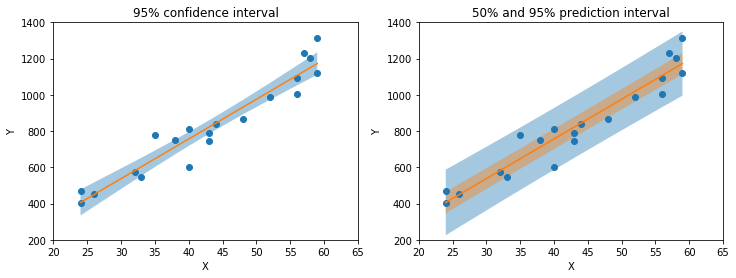

In [13]:
from statsmodels.stats.outliers_influence import summary_table

st, data, ss2 = summary_table(fitted, alpha=0.05)

fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(df['X'], df['Y'], 'o')
ax[0].plot(df['X'], fittedvalues)
ax[0].fill_between(df['X'], predict_mean_ci_low, predict_mean_ci_upp, alpha=0.4)
ax[0].set_xlim(20, 65)
ax[0].set_ylim(200, 1400)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('95% confidence interval')

ax[1].plot(df['X'], df['Y'], 'o')
ax[1].plot(df['X'], fittedvalues)
ax[1].fill_between(df['X'], predict_ci_low, predict_ci_upp, alpha=0.4)

st, data, ss2 = summary_table(fitted, alpha=0.5)

fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_ci_low, predict_ci_upp = data[:,6:8].T

ax[1].fill_between(df['X'], predict_ci_low, predict_ci_upp, alpha=0.4)
ax[1].set_xlim(20, 65)
ax[1].set_ylim(200, 1400)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_title('50% and 95% prediction interval')

### stan

In [14]:
model = pystan.StanModel(file='./chap04/model/model4-5.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a5383320e5d818d976e59523c8e84c3c NOW.


In [15]:
stan_data = {
    'X': df['X'].values,
    'Y': df['Y'].values,
    'N': df.shape[0]
}
fit = model.sampling(data=stan_data, seed=1234)

In [16]:
fit

Inference for Stan model: anon_model_a5383320e5d818d976e59523c8e84c3c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -122.1    2.46  76.05 -277.1 -171.1 -121.3 -72.33  25.91    954    1.0
b      21.97    0.06    1.7  18.63  20.84  21.95  23.03  25.41    914    1.0
sigma  85.38    0.46  15.97   61.1  74.03  83.61   93.7 121.65   1185    1.0
lp__  -93.67    0.04   1.37 -97.08 -94.27 -93.33 -92.71 -92.17    939   1.01

Samples were drawn using NUTS at Sun Oct 22 15:52:38 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

/Users/tomohiro/Workspace/RStanBook/.env/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  This is separate from the ipykernel package so we can avoid doing imports until


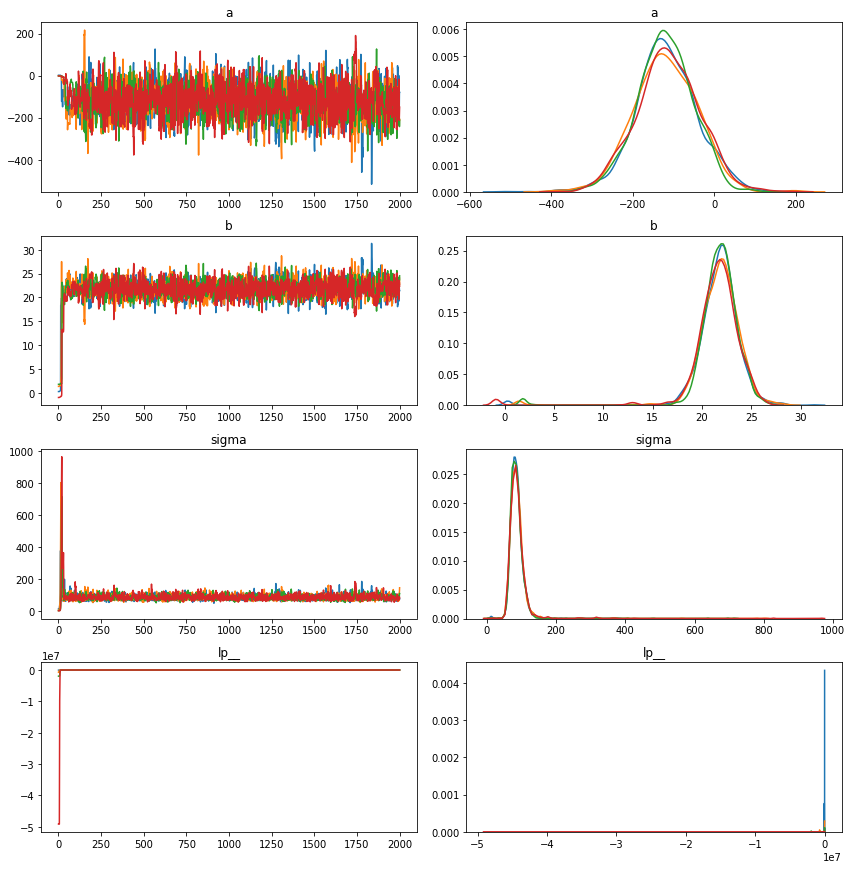

In [17]:
def mcmc_plot(fit):
    palette = sns.color_palette()
    ms = fit.extract(permuted=False, inc_warmup=True)
    iter_from = fit.sim['warmup']
    iter_range = np.arange(0, ms.shape[0])
    paraname = fit.sim['fnames_oi']

    plt.figure(figsize=(12, 12))
    for pos in range(4):
        pi = pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])

mcmc_plot(fit)

In [18]:
import random

stan_data = {
    'X': df['X'].values,
    'Y': df['Y'].values,
    'N': df.shape[0]
}

def initfunc():
    init_data = {
        'a': random.uniform(-10, 10),
        'b': random.uniform(-10, 10),
        'sigma': 10
    }
    return init_data

fit = model.sampling(data=stan_data, chains=3, iter=1000, warmup=200, thin=2, init=initfunc, seed=1234)

/Users/tomohiro/Workspace/RStanBook/.env/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  This is separate from the ipykernel package so we can avoid doing imports until


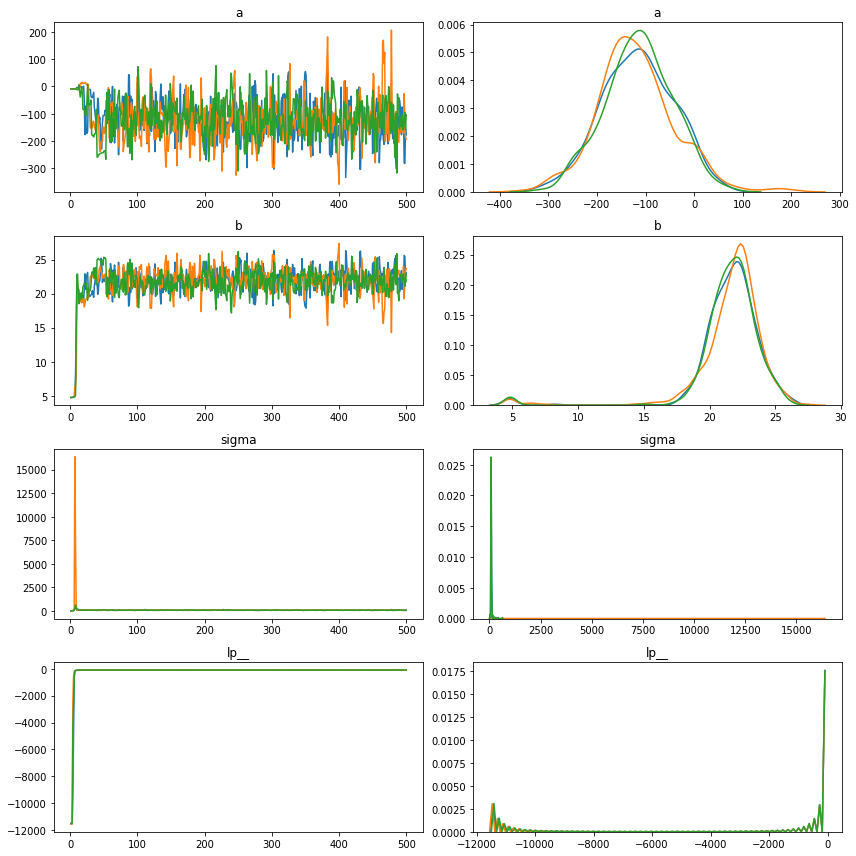

In [19]:
mcmc_plot(fit)

In [20]:
ms = fit.extract(permuted=False, inc_warmup=False)
df_ms = pd.DataFrame()
for i, col in enumerate(fit.sim['fnames_oi']):
    df_ms[col] = ms[:, :, i].reshape(-1, 1).flatten()

df_ms.describe(percentiles=[0.025, 0.975])

/Users/tomohiro/Workspace/RStanBook/.env/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  """Entry point for launching an IPython kernel.


,a,b,sigma,lp__
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,-121.233816,21.934574,84.695682,-93.551682
std,72.426941,1.618914,15.333992,1.288619
min,-357.916875,14.275900,53.336308,-100.434612
2.5%,-266.413937,18.475492,61.462856,-96.886211
50%,-121.975333,22.022786,82.841141,-93.191823
97.5%,36.212666,25.149333,119.725759,-92.120841
max,206.125284,27.375038,161.036938,-92.038333


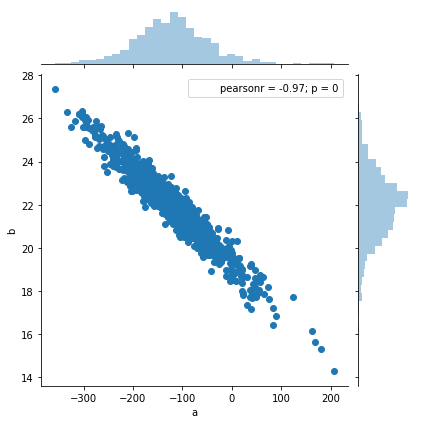

In [21]:
sns.jointplot(x='a', y='b', data=df_ms[['a', 'b']])

Text(0.5,1,'50% and 95% prediction interval')

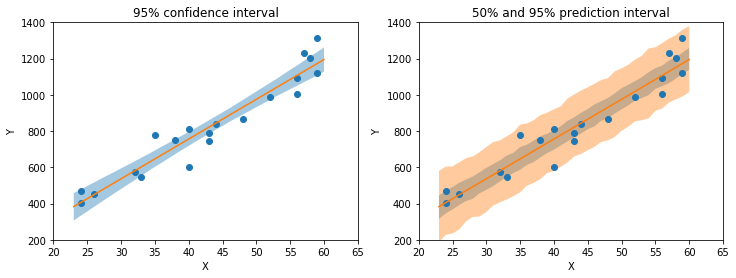

In [22]:
N_mcmc = df_ms.shape[0]
X_pred = np.arange(23, 61)
y_base_preds = np.zeros((len(X_pred), N_mcmc))
y_preds = np.zeros((len(X_pred), N_mcmc))
for i, x in enumerate(X_pred):
    y_base_preds[i] = df_ms['a'] + df_ms['b'] * x
    y_preds[i] = np.random.normal(loc=y_base_preds[i], scale=df_ms['sigma'], size=N_mcmc)


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(df['X'], df['Y'], 'o')
ax[0].plot(X_pred, y_base_preds.mean(axis=1))
ax[0].fill_between(X_pred, np.percentile(y_base_preds, 2.5, axis=1), np.percentile(y_base_preds, 97.5, axis=1), alpha=0.4)
ax[0].set_xlim(20, 65)
ax[0].set_ylim(200, 1400)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('95% confidence interval')

ax[1].plot(df['X'], df['Y'], 'o')
ax[1].plot(X_pred, y_base_preds.mean(axis=1))
ax[1].fill_between(X_pred, np.percentile(y_preds, 25.0, axis=1), np.percentile(y_preds, 75.0, axis=1), alpha=0.4)
ax[1].fill_between(X_pred, np.percentile(y_preds, 2.5, axis=1), np.percentile(y_preds, 97.5, axis=1), alpha=0.4)
ax[1].set_xlim(20, 65)
ax[1].set_ylim(200, 1400)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_title('50% and 95% prediction interval')

In [23]:
model = pystan.StanModel(file='./chap04/model/model4-4.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_703efebef0fb1f70bba7c6f9021a3eda NOW.


Text(0.5,1,'50% and 95% prediction interval')

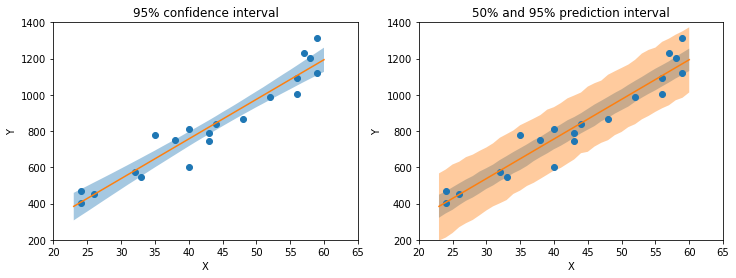

In [24]:
X_new = np.arange(23, 61)
N_new = len(X_new)
stan_data = {
    'X': df['X'].values,
    'Y': df['Y'].values,
    'N': df.shape[0],
    'X_new': X_new,
    'N_new': N_new
}
fit = model.sampling(data=stan_data, seed=1234)

y_base_new = fit.extract()['y_base_new'].T
y_new = fit.extract()['y_new'].T

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(df['X'], df['Y'], 'o')
ax[0].plot(X_new, y_base_new.mean(axis=1))
ax[0].fill_between(X_new, np.percentile(y_base_new, 2.5, axis=1), np.percentile(y_base_new, 97.5, axis=1), alpha=0.4)
ax[0].set_xlim(20, 65)
ax[0].set_ylim(200, 1400)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('95% confidence interval')

ax[1].plot(df['X'], df['Y'], 'o')
ax[1].plot(X_new, y_base_new.mean(axis=1))
ax[1].fill_between(X_new, np.percentile(y_new, 25.0, axis=1), np.percentile(y_new, 75.0, axis=1), alpha=0.4)
ax[1].fill_between(X_new, np.percentile(y_new, 2.5, axis=1), np.percentile(y_new, 97.5, axis=1), alpha=0.4)
ax[1].set_xlim(20, 65)
ax[1].set_ylim(200, 1400)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_title('50% and 95% prediction interval')

### exercise

In [25]:
np.random.seed(1234)

N1 = 30
N2 = 20
Y1 = np.random.normal(loc=0, scale=5, size=N1)
Y2 = np.random.normal(loc=1, scale=4, size=N2)

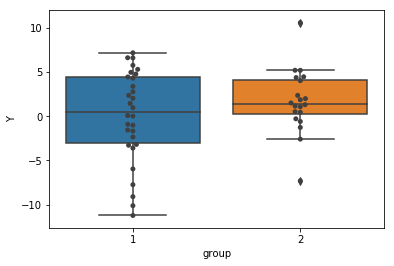

In [26]:
df_ex = pd.concat([
    pd.DataFrame({
        'Y': Y1,
        'group': [1] * len(Y1)
    }),
    pd.DataFrame({
        'Y': Y2,
        'group': [2] * len(Y2)
    })], axis=0)

sns.boxplot(x='group', y='Y', data=df_ex, )
sns.swarmplot(x="group", y="Y", data=df_ex, color=".25")

In [27]:
model1 = pystan.StanModel(file='./chap04/exercise/ex3.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a4d878ec635249c571d95707312b3d69 NOW.


In [28]:
stan_data = {
    'N1': N1,
    'N2': N2,
    'Y1': Y1,
    'Y2': Y2,
}
fit = model1.sampling(data=stan_data, seed=1234)

In [29]:
ms1 = fit.extract()
prob = np.mean(ms1['mu1'] < ms1['mu2'])
print(prob)

0.9015


In [30]:
model2 = pystan.StanModel(file='./chap04/exercise/ex5.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_731781fec7c01b149575d5d125def725 NOW.


In [31]:
stan_data = {
    'N1': N1,
    'N2': N2,
    'Y1': Y1,
    'Y2': Y2,
}
fit = model2.sampling(data=stan_data, seed=1234)

ms2 = fit.extract()
prob = np.mean(ms2['mu1'] < ms2['mu2'])
print(prob)

0.904
